$\LaTeX$ definitions:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [17]:
import arviz as az
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import corner
import pystan
import seaborn as sns

In [3]:
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

This is a very simple cosmology fitter using Stan's ODE solver function to compute luminosity distances and fit for a single density parameter and H0 (we assume a flat universe composed only of matter and dark energy, so $\Omega_m + \Omega_\Lambda = 1$).

The luminosity distance is given by ([Hogg, 1999](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=1999astro.ph..5116H&link_type=ABSTRACT))
$$
D_L(z) = \frac{c (1+z)}{H_0} \int_0^{z} \dd z \, \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}} = \frac{c (1+z)}{H_0} I(z),
$$
where 
$$
\diff{I}{z} = \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}},
$$
and 
$$
I(0) = 0.
$$
These are the equations we will feed to Stan's `ode_integrate_rk45` function.

First, we generate some mock data with (known) Gaussian uncertainty of 10% in the luminosity distance.

In [18]:
H0 = Planck15.H0.to(u.km/u.s/u.Mpc).value
Om = 0.3
Ol = 1-Om

my_cosmo = cosmo.FlatLambdaCDM(H0, Om)

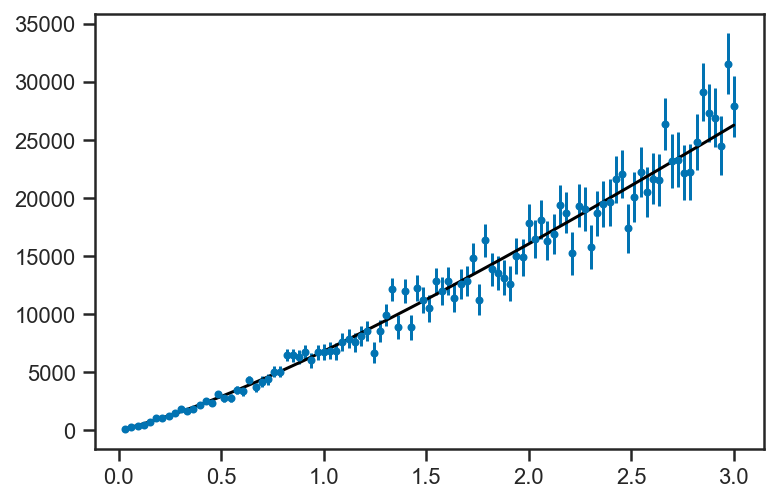

In [20]:
zs = linspace(0, 3, 100)
zs = zs[1:] # We don't want z = 0
dls_true = my_cosmo.luminosity_distance(zs).to(u.Mpc).value
sigma_dls = 0.1*dls_true
dls_obs = dls_true + sigma_dls*randn(dls_true.shape[0])

errorbar(zs, dls_obs, sigma_dls, fmt='.')
plot(zs, dls_true, '-k')

In [ ]:
model = pystan.StanModel(file='cosmography.stan')

In [21]:
cosmography_data = {'Nobs': zs.shape[0],
                    'dls_obs': dls_obs,
                    'sigma_dls_obs': sigma_dls,
                    'zobs': zs}

thin = 1

fit = model.sampling(data=cosmography_data, thin=thin, iter=2000*thin)
fit = az.convert_to_inference_data(fit)

/Users/wfarr/anaconda3/envs/StanCosmography/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wfarr/anaconda3/envs/StanCosmography/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wfarr/anaconda3/envs/StanCosmography/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124568650>,
      dtype=object)

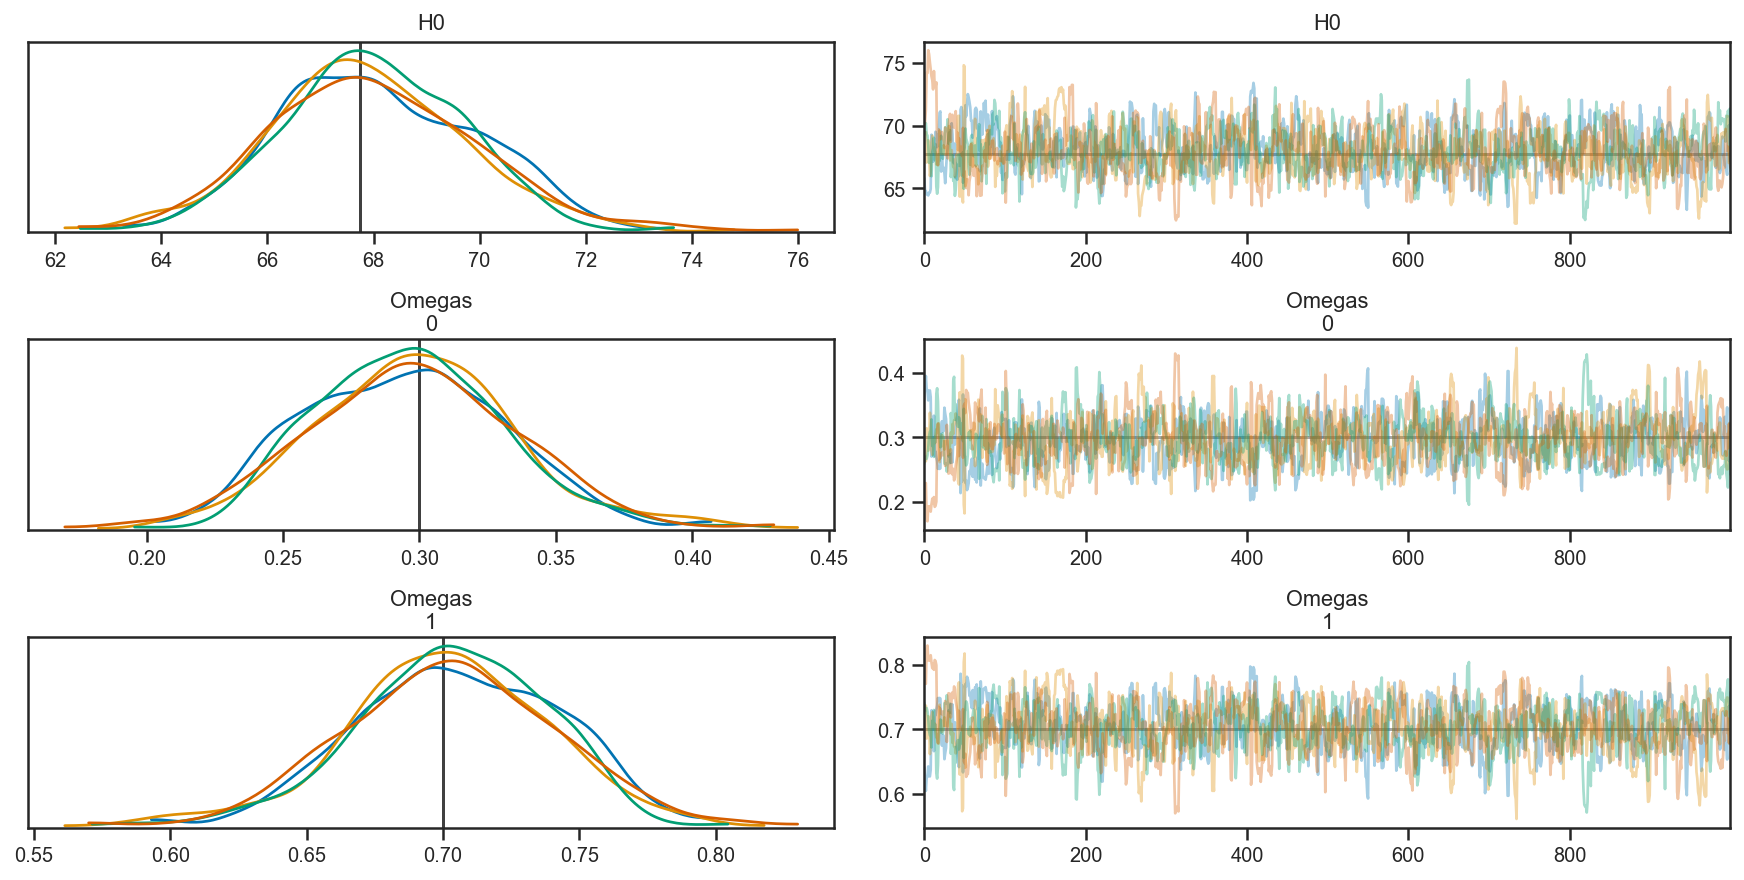

In [23]:
az.plot_trace(fit, var_names=['H0', 'Omegas'], lines=(('H0', {}, H0),
                                                      ('Omegas', {'Omegas_dim_0': 0}, Om),
                                                      ('Omegas', {'Omegas_dim_0': 1}, Ol)))

And, since we don't have any peculiar motion, or other measurement errors on the redshifts, we have really built a hierarchical, cosmological model of distance.  The plot below shows the data, the true redshift-distance relation, and the inferred distances of each object once we have fit the cosmology.  The posterior distance estimates have such tiny uncertainty because we do not have any uncertainty in the redshift, and we assume that the cosmological relation perfectly maps redshift to distance; the only remaining source of uncertainty comes from the cosmological parameters, and that is tiny.

Text(0, 0.5, '$d_L(z)$')

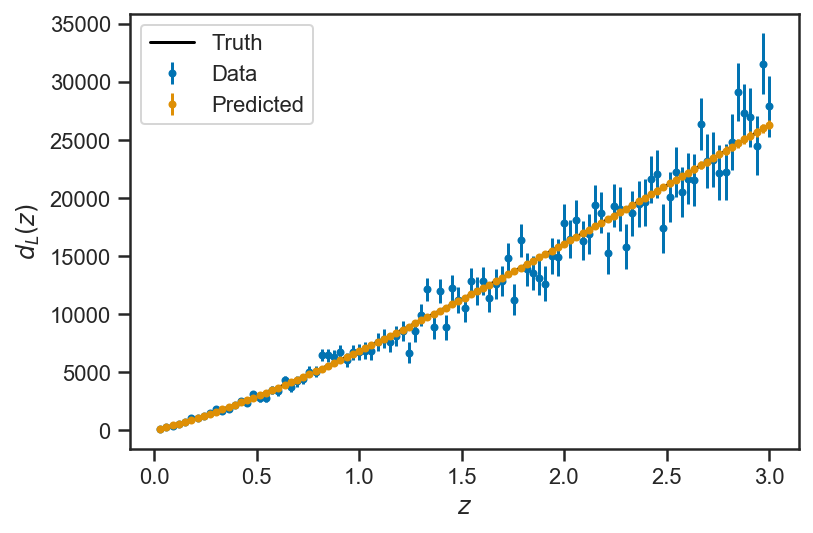

In [24]:
errorbar(zs, dls_obs, sigma_dls, fmt='.', label='Data')
errorbar(zs, mean(fit.posterior['dls_pred'], axis=(0,1)), std(fit.posterior['dls_pred'], axis=(0,1)), fmt='.', label='Predicted')
plot(zs, dls_true, '-k', label='Truth')
legend(loc='best')
xlabel(r'$z$')
ylabel(r'$d_L(z)$')